In [2]:
# try with xgb, see if it performs any better
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import time

from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image 
import pydotplus

In [3]:
# load the other three false positive datasets, and assign your own label
fp_Data = ["kplr_dr25_scr1_robovetter_input.txt", "kplr_dr25_inj2_robovetter_input.txt", "kplr_dr25_inj3_robovetter_input.txt"]

#################
#Class labels, 2 = scrammbled data, 3 = off planet injections, 4 is the injectied ecipsing binaries
###############3

n = 97 #num of cols
total_fp_data = np.empty(shape=[0, n])
total_fp_labels = np.empty(shape = [0,1]) # false positives lables
for i, file_name in enumerate(fp_Data):
    data = np.loadtxt(file_name, dtype=object , skiprows=223 ) 
    new_data = data[:, 4:] # get rid og the dataset label, TCE_ID, the KIC_ID, and pn
    print new_data.shape
    new_data = new_data.astype("float") # feautres
    total_fp_data = np.append(total_fp_data, new_data, axis = 0)
    labels = np.empty(shape=[new_data.shape[0],1])
    labels.fill(i+2)
    #print labels[0]
    total_fp_labels = np.append(total_fp_labels, labels)
print total_fp_data.shape, total_fp_labels.shape

(24213, 97)
(18897, 97)
(10502, 97)
(53612, 97) (53612,)


In [4]:
false_y = np.zeros(total_fp_data.shape[0])
print false_y.shape

data = np.loadtxt("kplr_dr25_inj1_robovetter_input.txt", dtype=object , skiprows=223 ) #[223:]
pc_data = data[:, 4:]
pc_data = pc_data.astype("float") # feautres
pc_y = np.ones(pc_data.shape[0])
print pc_y.shape

(53612,)
(45377,)


In [5]:
totalX = np.vstack([total_fp_data, pc_data])
totalY = np.hstack([false_y, pc_y])
classlabels = np.hstack([total_fp_labels, pc_y])

In [6]:
#print rfc.feature_importances_
#load labels, create pandaframe, and then run a fit to determine the most important features
data = pd.read_table("kplr_dr25_inj1_robovetter_input.txt",  skiprows=219 , sep= "|", nrows=1) #[223:]
data.rename(columns=lambda x: x.strip(), inplace=True)
del data["Unnamed: 0"]
del data["Unnamed: 102"]
del data["Data_Set"]
#print data.columns.values
del data["TCE_ID"]
del data["KIC"]
del data["pn"]



vals = data.columns.values
print vals
totalX = pd.DataFrame(totalX, columns=vals)
#labelled_data.head()



['n_plan' 'ntrans' 'nrealt' 'ngoodt' 'iflag0' 'iflag1' 'iflag2' 'iflag3'
 'iflag4' 'iflag5' 'cflag0' 'cflag1' 'cflag2' 'cflag3' 'cflag4' 'cflag5'
 'cflag6' 'cflag7' 'cflag8' 'ephem_disp' 'cent_disp' 'cent_score' 'period'
 'period_err' 'epoch' 'epoch_err' 'duration' 'duration_err' 'impact'
 'impact_err' 'depth' 'depth_err' 'depth_alt' 'sma' 'rstar' 'mes'
 'ses_to_mes' 'new_mes' 'lpp_dv' 'lpp_alt' 'all_tran_chases' 'sweet_snr'
 'sweet_amp' 'shape_metric' 'halo_ghost' 'mod_sig_pri_dv' 'mod_sig_sec_dv'
 'mod_sig_ter_dv' 'mod_sig_pos_dv' 'mod_fred_dv' 'mod_fa1_dv' 'mod_fa2_dv'
 'mod_sig_pri_alt' 'mod_sig_sec_alt' 'mod_sig_ter_alt' 'mod_sig_pos_alt'
 'mod_fred_alt' 'mod_fa1_alt' 'mod_fa2_alt' 'modshiftval1_dv'
 'modshiftval2_dv' 'modshiftval3_dv' 'modshiftval4_dv' 'modshiftval5_dv'
 'modshiftval6_dv' 'modshiftval1_alt' 'modshiftval2_alt' 'modshiftval3_alt'
 'modshiftval4_alt' 'modshiftval5_alt' 'modshiftval6_alt' 'oesig_dv'
 'oesig_alt' 'mod_oe_dv' 'mod_oe_alt' 'rp_dv' 'rp_dv_perr' 'rp_dv_me

In [7]:
#shuffle then split
shuffleX, shuffleY, shuffle_labels = shuffle(totalX, totalY, classlabels, random_state = 0)


In [8]:
# take samples of the data to see the minimum needed for good performance
sampleX, ignoreX, sampleY,  ignoreY = train_test_split(shuffleX , shuffleY, stratify = totalY, random_state = 5, 
                                                      train_size = 0.1)
print sampleX.shape, sampleY.shape
xgb_c = XGBClassifier(n_estimators=100, seed = 0, min_child_weight=5, colsample_bytree=0.8)
size_dtrain = xgb.DMatrix(sampleX, label=sampleY)
xgb_params = xgb_c.get_xgb_params()

score = xgb.cv(xgb_params, nfold=5, dtrain=size_dtrain,  metrics="auc",
                   stratified=True, early_stopping_rounds=20, verbose_eval=True, seed=0)
xgb_c.fit(sampleX, sampleY)
preds = xgb_c.predict(ignoreX)
score = sklearn.metrics.average_precision_score(ignoreY, preds)
print score
score = sklearn.metrics.roc_auc_score(ignoreY, preds)
print score

(9898, 97) (9898,)
[0]	train-auc:0.858053+0.00330574	test-auc:0.852892+0.00830541
[1]	train-auc:0.909551+0.00269349	test-auc:0.907212+0.00545867
[2]	train-auc:0.910299+0.00286816	test-auc:0.908644+0.00582347
[3]	train-auc:0.915719+0.00204672	test-auc:0.914229+0.00465999
[4]	train-auc:0.923309+0.0064821	test-auc:0.919895+0.00513788
[5]	train-auc:0.928964+0.0059842	test-auc:0.926043+0.00567649
[6]	train-auc:0.93348+0.00509367	test-auc:0.931157+0.00829775
[7]	train-auc:0.937261+0.00246061	test-auc:0.934034+0.00847346
[8]	train-auc:0.942107+0.00194295	test-auc:0.939296+0.00378582
[9]	train-auc:0.94265+0.0016875	test-auc:0.939281+0.00349076
0.906449674348
0.893653567821


In [9]:
#create holdout set
keepX,  holdoutX, keepY, holdoutY , keep_labels, holdout_labels= train_test_split(shuffleX, shuffleY, shuffle_labels, test_size = 0.2, random_state = 0)
print keepX.shape, holdoutX.shape

(79191, 97) (19798, 97)


In [10]:
# work with the top 20 features determined by xgb, as well as the features determined by the Robovetter team
xgbc = XGBClassifier(n_estimators=100, max_depth=10, subsample=0.9, seed=0)

#rfc = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)
start = time.time()
#score = cross_val_score(rfc, keepX, keepY, cv = 5, scoring="average_precision", verbose=True )
xgb_params = xgbc.get_xgb_params()
dtrain = xgb.DMatrix(keepX, label=keepY)
#score = xgb.cv(xgb_params, nfold=5, dtrain=dtrain,  metrics="auc",
#               stratified=True, early_stopping_rounds=20, verbose_eval=True, seed=30)

xgbc.fit(keepX, keepY)
preds =xgbc.predict(holdoutX) 
score = sklearn.metrics.average_precision_score(holdoutY, preds)
print score 
score = sklearn.metrics.precision_score(holdoutY, preds)
print "Precision", score
score = sklearn.metrics.recall_score(holdoutY, preds)
print "Recall", score

0.920309575301
Precision 0.88037829973
Recall 0.926095987756


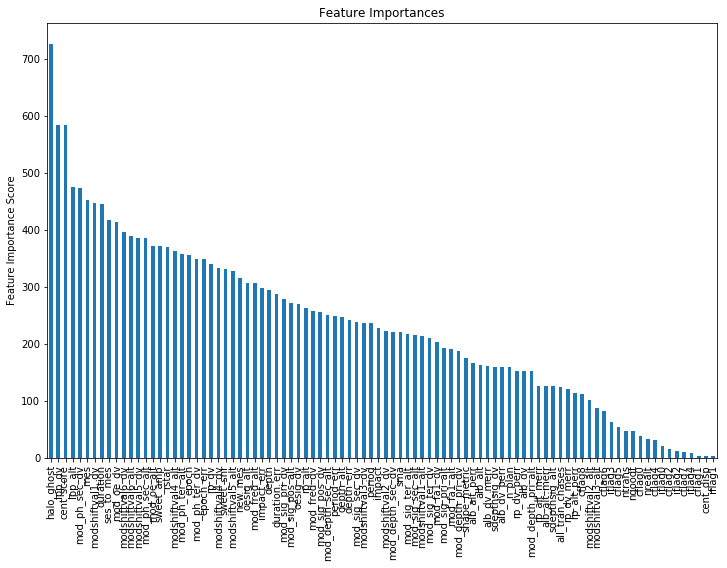

In [11]:
# feature importances
feat_imp = pd.Series(xgbc.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [89]:
print feat_imp[:20]
xgb_imp_feat = list(feat_imp[:40].index)

halo_ghost          727
lpp_dv              584
cent_score          584
lpp_alt             475
mod_ph_sec_dv       474
mes                 453
modshiftval1_dv     447
duration            446
ses_to_mes          418
mod_oe_dv           415
modshiftval6_dv     397
modshiftval6_alt    389
modshiftval5_dv     387
mod_ph_sec_alt      387
mod_oe_alt          372
sweet_amp           372
rstar               371
modshiftval4_alt    363
mod_ph_ter_alt      358
epoch               356
dtype: int64


In [12]:
seeds = np.random.randint(100, size=10)
print seeds

[96 14 83 78 11 12 70 32 11  9]


In [37]:
xgbc = XGBClassifier(n_estimators=100, max_depth=10, subsample=0.9, seed=0)
mean_test_auc = []

for rand_Seed in seeds:
    #rfc = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)
    start = time.time()
    #score = cross_val_score(rfc, keepX, keepY, cv = 5, scoring="average_precision", verbose=True )
    xgb_params = xgbc.get_xgb_params()
    dtrain = xgb.DMatrix(keepX, label=keepY)
    score = xgb.cv(xgb_params, nfold=5, dtrain=dtrain,  metrics="auc",
                   stratified=True, early_stopping_rounds=20, verbose_eval=True, seed=rand_Seed)
    print score 
    print "Average score", np.mean(score), "Standard Deviation", np.std(score)
    end = time.time()
    print("Total evaluation time %f" % (end - start))
    mean_test_auc.append(np.mean(score["test-auc-mean"]))
    print mean_test_auc

[0]	train-auc:0.953268+0.000939747	test-auc:0.945645+0.00173728
[1]	train-auc:0.956179+0.00043019	test-auc:0.948744+0.000975845
[2]	train-auc:0.957573+0.000573388	test-auc:0.95009+0.000894179
[3]	train-auc:0.958719+0.000306624	test-auc:0.951138+0.00127565
[4]	train-auc:0.959365+0.000317166	test-auc:0.951677+0.00127698
[5]	train-auc:0.960056+0.000387564	test-auc:0.952127+0.00126962
[6]	train-auc:0.960822+0.000442147	test-auc:0.952684+0.00112738
[7]	train-auc:0.961454+0.000380545	test-auc:0.953052+0.00113584
[8]	train-auc:0.962254+0.000330022	test-auc:0.953451+0.00108344
[9]	train-auc:0.962802+0.000343034	test-auc:0.953769+0.00106532
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.945645      0.001737        0.953268       0.000940
1       0.948744      0.000976        0.956179       0.000430
2       0.950090      0.000894        0.957573       0.000573
3       0.951138      0.001276        0.958719       0.000307
4       0.951677      0.001277        0.959365    

Begin parameter tuning with hyperopt

In [19]:
#check accuracy score
xgbc = XGBClassifier(n_estimators=100, max_depth=10, subsample=0.9, seed=0)

for rand_Seed in seeds[:3]:
    #rfc = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)
    start = time.time()
    #score = cross_val_score(rfc, keepX, keepY, cv = 5, scoring="average_precision", verbose=True )
    xgb_params = xgbc.get_xgb_params()
    dtrain = xgb.DMatrix(keepX, label=keepY)
    score = xgb.cv(xgb_params, nfold=5, dtrain=dtrain,  metrics="error",
                   stratified=True, early_stopping_rounds=20, verbose_eval=True, seed=rand_Seed)
    #print score 
    #print "Average score", np.mean(score), "Standard Deviation", np.std(score)
    #end = time.time()
    #print("Total evaluation time %f" % (end - start))
    #print sklearn.metrics.

[0]	train-error:0.096485+0.00106527	test-error:0.112879+0.00219787
[1]	train-error:0.0921316+0.00112974	test-error:0.108346+0.00143887
[2]	train-error:0.090569+0.00162261	test-error:0.106767+0.00122034
[3]	train-error:0.0888294+0.00138739	test-error:0.105529+0.000686594
[4]	train-error:0.0883686+0.00161286	test-error:0.104898+0.000673587
[5]	train-error:0.0872164+0.00132474	test-error:0.104557+0.000987483
[6]	train-error:0.0864586+0.00140222	test-error:0.104381+0.000830277
[7]	train-error:0.0857198+0.00158138	test-error:0.102928+0.000602079
[8]	train-error:0.0852338+0.00138512	test-error:0.102815+0.000619278
[9]	train-error:0.0845772+0.00127768	test-error:0.102575+0.000872057
[0]	train-error:0.0966806+0.000666386	test-error:0.111818+0.00234915
[1]	train-error:0.0929714+0.00112397	test-error:0.108598+0.00144344
[2]	train-error:0.0906288+0.000597942	test-error:0.10683+0.00197602
[3]	train-error:0.0891138+0.000392393	test-error:0.10635+0.00234471
[4]	train-error:0.0882014+0.000688647	test

In [105]:
#custom precsion and recall
def prec_err(preds, labels):
    #print preds.shape
    labels = labels.get_label()
    print preds.max()
    pred_num = len(np.where((preds>=0.6) & (labels ==1))[0])
    total_num = len(np.where( preds >=0.6)[0])
    print pred_num ,total_num
    score = pred_num/float(total_num)
    score_list = np.empty_like(preds)
    score_list.fill(score)
    #print score_list
    #return ["preds", score]
    return "error", score


#def rec_err(preds, labels):
 #   pred_num = len(np.where((preds==1) & (labels ==1)[0])
    #total_num = len(np.where(labels ==1)[0])
    #return pred_num/float(total_num)


In [106]:
xgbc = XGBClassifier(n_estimators=300, max_depth=10, subsample=0.9, seed=0,)
#try with xgb top 20 feates
#rfc = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)
start = time.time()
#score = cross_val_score(rfc, keepX, keepY, cv = 5, scoring="average_precision", verbose=True )
xgb_params = xgbc.get_xgb_params()
dtrain = xgb.DMatrix(keepX, label=keepY)
score = xgb.cv(xgb_params, nfold=5, dtrain=dtrain, feval=prec_err,
               stratified=True, early_stopping_rounds=20, verbose_eval=True, seed=10)
print score 
print "Average score", np.mean(score), "Standard Deviation", np.std(score)
end = time.time()
print("Total evaluation time %f" % (end - start))
mean_test_auc.append(np.mean(score["test-error-mean"]))
print mean_test_auc

0.547082
0 0


ZeroDivisionError: float division by zero

In [ ]:
#xgboost.to_graphviz(booster, fmap='', num_trees=0, rankdir='UT', yes_color='#0000FF',
    #no_color='#FF0000', **kwargs#
xgb.to_graphviz(xgbc, num_trees=1)# feature_names = labelled_data.columns.values)

In [28]:
# check if the splits are stratified
print len(np.where(holdoutY==1)[0])
print len(np.where(holdoutY==0)[0])
print len(np.where(keepY==1)[0])
print len(np.where(keepY==0)[0])


# try splitting the data again, and then running the individual training and testing to see if that improves scores
keepX_s,  holdoutX_s, keepY_s, holdoutY_s , keep_labels_s, holdout_labels_s= train_test_split(shuffleX,
                            shuffleY, shuffle_labels, test_size = 0.2, random_state = 0, stratify = shuffleY)
print("\n")
print len(np.where(holdoutY_s==1)[0])
print len(np.where(holdoutY_s==0)[0])
print len(np.where(keepY_s==1)[0])
print len(np.where(keepY_s==0)[0])

9147
10651
36230
42961


9075
10723
36302
42889


In [ ]:
#xgbc = XGBClassifier(n_estimators=100, max_depth=10, subsample=0.9, seed=4)
#xgbc.fit(keepX_s, keepY_s)
#preds = xgbc.predict(holdoutX_s)


In [35]:
score = sklearn.metrics.roc_auc_score(holdoutY_s, preds)
print "ROC_auc", score
score = 1 - sklearn.metrics.accuracy_score(holdoutY_s, preds)
print "Error", score
score = sklearn.metrics.average_precision_score(holdoutY_s, preds)
print "PR_AUC", score


ROC_auc 0.911759234353
Error 0.0900090918275
PR_AUC 0.920970663555


In [86]:
# define the parameter space and objective
space3 ={
        'max_depth': hp.quniform('x_max_depth', 1, 15,1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
        'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1)
}

In [91]:
def objective4(space3):

    clf = XGBClassifier(n_estimators = 500, 
                            max_depth = space3['max_depth'], 
                            min_child_weight =space3['min_child_weight'],
                            subsample = space3['subsample'],
                            colsample_bytree =space3['colsample_bytree'],
                            learning_rate = space3['learning_rate'])
    start = time.time()
    dtrain= xgb.DMatrix(shuffleX[xgb_imp_feat], label=shuffleY)
    cv_result = xgb.cv(clf.get_xgb_params(),dtrain, num_boost_round=10, nfold=5, feval=prec_err, early_stopping_rounds=5 , seed=0, stratified=True)
    end = time.time()
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    score =  cv_result.iloc[-1]["test-error-mean"]
    score_std =  cv_result.iloc[-1]["test-error-std"]
    print ("SCORE %f, in : %f s:" % (score, (end-start)))

    return{'loss':1-score, 'status': STATUS_OK, "cv_score":score, "test_avg": score_std }

In [92]:
trials4= Trials()
import time
start = time.time()
best4 = fmin(fn=objective4, space = space3, algo = tpe.suggest, max_evals = 20, trials = trials4)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE 0.843700, in : 6.204770 s:
SCORE 0.839148, in : 9.065809 s:
SCORE 0.849142, in : 9.593556 s:
SCORE 0.848535, in : 9.481226 s:
SCORE 0.607200, in : 3.325968 s:
SCORE 0.837891, in : 8.971814 s:
SCORE 0.847810, in : 13.151676 s:
SCORE 0.847878, in : 13.234824 s:
SCORE 0.841843, in : 6.972290 s:
SCORE 0.800036, in : 3.107779 s:
SCORE 0.842370, in : 7.390899 s:
SCORE 0.845831, in : 10.027797 s:
SCORE 0.846192, in : 7.299150 s:
SCORE 0.839929, in : 4.234407 s:
SCORE 0.842243, in : 7.054643 s:
SCORE 0.847039, in : 8.083636 s:
SCORE 0.843842, in : 8.656969 s:
SCORE 0.839452, in : 4.448149 s:
SCORE 0.849153, in : 7.533060 s:
SCORE 0.846406, in : 7.826699 s:
('Optimization Time: %f seconds', 155.7992241382599)


In [120]:
print best4

{'x_min_child': 1.0, 'x_tree_colsample': 0.9772742007628381, 'x_max_depth': 9.0, 'x_subsample': 0.9496252732199657, 'x_learning_rate': 0.09070813376764114}


In [16]:
best4 = {'x_min_child': 1.0, 'x_tree_colsample': 0.9772742007628381,
         'x_max_depth': 9.0, 'x_subsample': 0.9496252732199657,
         'x_learning_rate': 0.09070813376764114}
print best4


{'x_min_child': 1.0, 'x_tree_colsample': 0.9772742007628381, 'x_max_depth': 9.0, 'x_subsample': 0.9496252732199657, 'x_learning_rate': 0.09070813376764114}


In [19]:
best = [best4]#, best5]
for best_params in best:
    xgb_c = XGBClassifier(n_estimators=500, seed=0, min_child_weight=best_params["x_min_child"],
                         max_depth = int(best_params["x_max_depth"]), subsample = best_params["x_subsample"], 
                         learning_rate = best_params["x_learning_rate"], colsample_bytree = best_params["x_tree_colsample"])
    xgb_c.fit(keepX[xgb_imp_feat], keepY) # the orignal 80
    preds = xgb_c.predict(holdoutX[xgb_imp_feat]) #3 the holdout 20 percent
    score = sklearn.metrics.average_precision_score(holdoutY, preds)
    print score
    break

0.914828482639


In [20]:
score = sklearn.metrics.roc_auc_score(holdoutY, preds)
print score

0.903700598627


In [24]:
#a bit confused about the low test scores, as the scores for the test set for cv were significanlty higher
#manually define best4 and best5 so the optimzation doesnt need to be rerun


best4 = {'x_min_child': 7.0, 'x_tree_colsample': 0.6437984135576709, 'x_max_depth': 10.0, 'x_subsample': 0.8828911873690336, 'x_learning_rate': 0.024538070738830416}
#best4 = {'x_min_child': 8.0, 'x_tree_colsample': 0.6437984135576709, 'x_max_depth': 15, 'x_subsample': 0.50, 'x_learning_rate': 0.024538070738830416}

best5 = {'x_min_child': 8.0, 'x_tree_colsample': 0.9355209227945037, 'x_max_depth': 13.0, 'x_subsample': 0.8888132119145556, 'x_learning_rate': 0.039567638307710734}


best = [best4, best5]
for best_params in best:
    start = time.time()
    xgbc = XGBClassifier(n_estimators=500, seed=0, min_child_weight=best_params["x_min_child"],
                         max_depth = int(best_params["x_max_depth"]), subsample = best_params["x_subsample"], 
                         learning_rate = best_params["x_learning_rate"], colsample_bytree = best_params["x_tree_colsample"],
                         )
    xgbc.fit(keepX, keepY) # 80% of the 80 
    preds = xgbc.predict(holdoutX) #205 of the 80%
    score = sklearn.metrics.average_precision_score(holdoutY,  preds)
    print score
    end = time.time()
    print "Train test time", (end - start)
    #break
    

0.920799858919
Train test time 196.238195896
0.921149698672
Train test time 344.452687025
